# Histopathologic Cancer Detection with CNNs

The goal of this study is to produce a model that can reliably detect metastatic cancer when given a histopathologic scan obtained from sections of the lymph node. Such a model could assist medical professionals with identifying cancer and thus saving lives. Once a good model has been identified, it will be entered into a Kaggle competition.

It should be possible to replicate this study in a Jupiter Notebook environment that comes equipped with GPU hardware, such as Google Colab.

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
from matplotlib import image as showimg
from PIL import Image
import cv2

### Data Description
The Histopathologic Cancer Detection dataset can be downloaded from [kaggle](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data). These data are a clean version of the  PatchCamelyon (PCam) dataset, which can be found on [github](https://github.com/basveeling/pcam). 

Contained therein are 220,025 labeled training images with RGB color channels, which are histopathologic scans obtained from sections of participants' lymph nodes. Each image is 96x96px.

A label of '1' indicates that there is cancer in the middle 32x32px portion of the image. A label of '0' means otherwise. Please note that there can be cancer in an image and yet be correctly labeled as "no cancer", if the cancer is outside of the central 32x32px block of the image. This labeling scheme supposedly imporoves performance of CNNs without padding layers.

#### Acknowledgements
[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". [arXiv:1806.03962](http://arxiv.org/abs/1806.03962)

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. [doi:jama.2017.14585](https://doi.org/10.1001/jama.2017.14585)

In [2]:
#download data
!mkdir /root/.kaggle
!cp kaggle.json ../root/.kaggle
!ls ../root/.kaggle
!kaggle competitions download -c histopathologic-cancer-detection
!unzip -q histopathologic-cancer-detection.zip -d histopathologic-cancer-detection

kaggle.json
100% 6.28G/6.31G [00:53<00:00, 129MB/s] 
100% 6.31G/6.31G [00:53<00:00, 126MB/s]


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

### Data Cleaning and Exporatory Data Analysis

It is important that the local copy of the dataset meet the standards outlined in its metadata. Once the data has been ascertained clean, an exploratory analysis can be conducted to identify the course of action in the modeling phase. 

In [ ]:
!ls -U histopathologic-cancer-detection/train | head -10

0edeae9c8ea33d940c487d009ccff492ca0ce025.tif
80176933b993704a69c3a44823ca601cc43606c7.tif
9dc814d5754c513008bc02acc1dfb095218ed109.tif
1b8fbbf93ad72e259e6b845d64c8395b84da6742.tif
2614220ff5c08a5943e842b9175cc7a83e5fd638.tif
6023df3d160f8f2e31520e411c019eda0d26ccc7.tif
e279081ba377a2e17e47cc7117834f6ae255bc38.tif
0920cc3605250ef6d18b808baf880936558ab768.tif
06ae00a0f2784392944128456f3f160d39dc0c19.tif
86c2d0d778f0d49c278b667b20b63aeb533236b6.tif


The images are encoded in an .TIF format, which is relativelly uncommon. It is important to note this because some Keras image processors cannot process these types of images, namely the tf.keras.utils.image_dataset_from_directory function.

In [ ]:
im = Image.open('histopathologic-cancer-detection/train/{}'.format('0edeae9c8ea33d940c487d009ccff492ca0ce025.tif'))
w, h = im.size
print("Width of Image: {}px\n Height of Image: {}px".format(w,h))

Width of Image: 96px
 Height of Image: 96px


In [3]:
data = pd.read_csv('/content/histopathologic-cancer-detection/train_labels.csv')
data["id"] += ".tif"
data['label'] = data['label'].astype('str')
print("Total Number of Training Images: {}".format(len(data)))

Total Number of Training Images: 220025


In [ ]:
for row in data.iterrows():
  file = row[1]['id']
  im = Image.open('histopathologic-cancer-detection/train/{}'.format(file))
  w,h = im.size
  if w != 96 and h != 96:
    print("Unusual File", file, w, h)

The data are clean, given that nothing unusal has been detected. All images are in the same format and have identical dimensions. 

In [4]:
np.random.seed(123) #makes this deterministic
train_ind = np.random.choice([*range(0,len(data))], replace=False, size = int(0.9 * len(data)))

train_data = data.iloc[train_ind]

val_data = data.iloc[~data.index.isin(train_ind)]
print("Training: {}, Validation: {}".format(len(train_data), len(val_data)))

Training: 198022, Validation: 22003


In order to perform an effective analysis, data should be split into a training set and a validation set. The data contained in the validation set won't be used to train the model. Instead, it will be used to evaluate the model's performance to ensure that it generalizes well with data it wasn't trained on. 

The random seed insures that the results of subsequent model training and evaluation are deterministic and replicable.

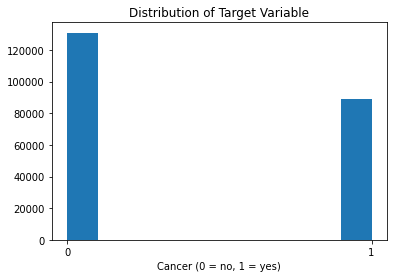

In [ ]:
plt.title("Distribution of Target Variable")
plt.xlabel("Cancer (0 = no, 1 = yes)")
plt.hist(data['label'])
plt.show()

The distribution of the target variable is somewhat unbalanced. There seems to be more labels representing "No Cancer". As a result, the accuracy score may not be the best measure of model performance. This is not to say that it is useless, given that the data are only slighly unbalanced. Recall, F1 and AUC though may be better measures though.

#### Preprocessing

In [10]:
def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

train_imgs = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale = 1.0/255.0, #remove this if need be to do EDA
            horizontal_flip=True,
            vertical_flip=True,
            preprocessing_function=orthogonal_rot
).flow_from_dataframe(
              dataframe=train_data,
              directory="histopathologic-cancer-detection/train",
              x_col="id",
              y_col="label",
              subset="training",
              batch_size = 256,
              class_mode="binary",
              target_size=(96,96))

Found 198022 validated image filenames belonging to 2 classes.


In [11]:
val_imgs = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale = 1.0/255.0,
            horizontal_flip=True,
            vertical_flip=True,
            preprocessing_function=orthogonal_rot
).flow_from_dataframe(
              dataframe=val_data,
              directory="histopathologic-cancer-detection/train",
              x_col="id",
              y_col="label",
              subset="training",
              batch_size = 256,
              class_mode="binary",
              shuffle = False,
              target_size=(96,96))

Found 22003 validated image filenames belonging to 2 classes.


The training and validation sets should be in a format that Keras can work with.  It is also good practice to normalize the images, which is what is done in the code above. 

Image augmentation should reduce generalization error in soon to be trained models. Special care must be taken when performing any image augmentation given that displacing the central 32x32px section of the image, which determines the classification, could result in a reduction in model performance. As a result, only orthogonal rotations and flip operations are permitted. These operations do not affect the location of the critical 32x32px central area.

The batch size of 256 was determined from hyperparameter tuning, as this particular size seems to be optimal for minimizing training loss.

In [9]:
samp_x, samp_y = next(iter(train_imgs))

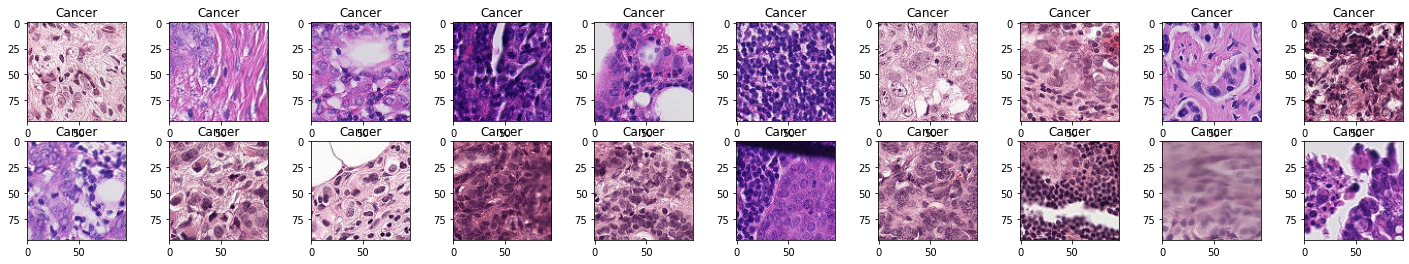

In [ ]:
#note - these images were generate before rescaling. To replicate, just remove the rescaling attribute from the ImageDataGenerator
plt.figure(figsize=(25,4))
for (i,img) in enumerate(samp_x[samp_y == 1][:20]):
  plt.subplot(2, 10, i+1)
  plt.title("Cancer")
  plt.imshow(img / 255.)

The images depicted above represent scans in which at least 1 pixel of cancer exists in the central 32x32px section. These images are in color, which is expected.

The geometric objects depicted in the image appear to be primarily simple: blobs, strands of tissue, simple tectures. This seems to indicate that a large, deep and complex model is unnecessary. Rather, a smaller model should be sufficient for the purposes of classifying the dataset.

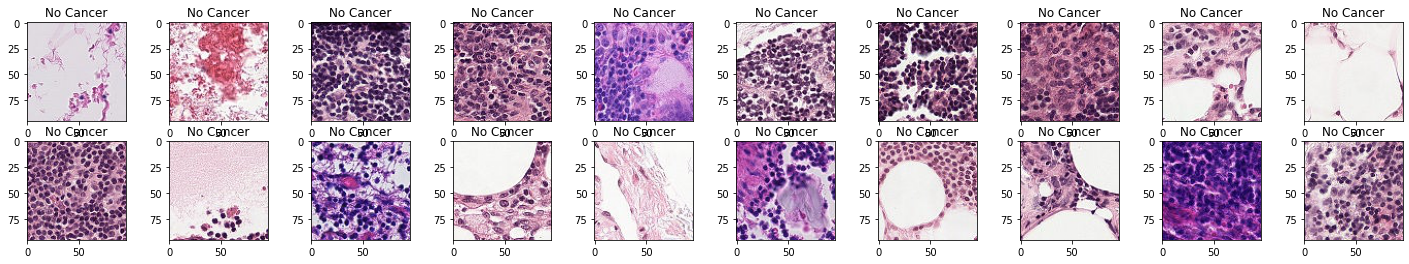

In [ ]:
plt.figure(figsize=(25,4))
for (i,img) in enumerate(samp_x[samp_y == 0][:20]):
  plt.subplot(2, 10, i+1)
  plt.title("No Cancer")
  plt.imshow(img / 255.)

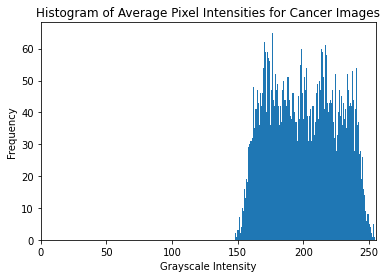

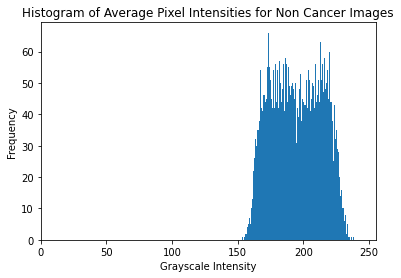

In [27]:
cancer = samp_x[samp_y == 1]
noCancer = samp_x[samp_y == 0]

canc_intensities = np.array([float(x) for x in range(0, 96 * 96)])
for image in cancer:
  canc_intensities += image.mean(axis=2).flatten()

b, bins, patches = plt.hist(canc_intensities / len(cancer), 255)
plt.xlim([0,255])
plt.title("Histogram of Average Pixel Intensities for Cancer Images")
plt.xlabel("Grayscale Intensity")
plt.ylabel("Frequency")
plt.show()

no_intensities = np.array([float(x) for x in range(0, 96 * 96)])
for image in noCancer:
  no_intensities += image.mean(axis=2).flatten()

b, bins, patches = plt.hist(no_intensities / len(noCancer), 255)
plt.title("Histogram of Average Pixel Intensities for Non Cancer Images")
plt.xlabel("Grayscale Intensity")
plt.ylabel("Frequency")
plt.xlim([0,255])
plt.show()

It is can be difficult to identify whether or not there is cancer in the training images, especially for individuals who are not domain experts. Above are histograms displaying the average grayscale intensities of pixels for both samples of images showing and not showing cancer. This was done in an attempt to differentiate the images. It appears that images labeled cancer have more bright pixels. This seems to indicate that high intensity pixels may be an identifying characteristic of cancer in these images.

#### Analysis Plan

Based off of the exploratory data analysis, the dataset is made up of small (96x96) image depicting simple geometric shapes. A transfer learning base model, which had already learned simple image features, may be a useful tool to build models upon. Since these images are small, a very large base model may not be necessary. Because cancer is generally brighter in intensity, a simple model should be able to pick up on this easily. 

### Discussion on Model Architecture 

To keep from "Re-inventing the wheel", I chose to make use of popular existing neural network architectures detailed on the [Keras Applications](https://keras.io/api/applications/) page. All the models listed were trained on the imagenet database and were demonstated to be effective classifiers. The final layer of any of these pre-trained neural networks can be removed so that the model outputs the constituent image features it learned to detect, instead of a classification label from the dataset the architecture was trained on. 

These features can then be used as input into another neural network, which generates a desired label as output (e.g. cancer? yes/no). In this study, three pre-trained architectures are each used to extract features from the cancer scans. These features are then used as input to train a custom multi-layer neural network that returns a probability. 

I have found that large architectures (>30 million parameters), perform relatively poorly. My hypothesis is that the geometric objects represented in these images are simple and are not represented in output from complex feature extractors. It is also possible that these images are too small and do not contain enough information to make a large network worthwhile.

Through extensive hyperparameter tuning, I have found that a 6 layered network each containing a power of 2 number of nodes produces good results. Furthermore, batch normalization proved to be a very useful addition to the architecture, based on extensive tuning from training the model on a subset of batches.

For sake of brevity, output has been cleared from the code cells below. Also excluded are the numerous rounds of experimentation performed to tune hyperparameters. This typically involved tedious cycles of adjustments followed by training on a subset of batches to monitor performance.

In [ ]:
base_model = tf.keras.applications.VGG19(
    weights='imagenet',  
    input_shape=(96, 96, 3),
    include_top=False) 
base_model.trainable = False #dont want to train this yet

x = base_model.output

#my custom NN
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Flatten()(x)
predictions = tf.keras.layers.Dense(512, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(256, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(128, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(64, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(predictions)


model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
  
model.summary()

In [ ]:
print(len(base_model.layers))

22


VGG19 is a popular neural network architecture that is known to generalize well to new datasets. For this reason, I decided to include it in this study. More details about this neural network can be found [here](https://arxiv.org/abs/1409.1556). This is a somewhat shallow architecture, with only 22 layers. 

In [ ]:

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  
    input_shape=(96, 96, 3),
    pooling = "average",
    include_top=False) 

base_model.trainable = False #dont want to train this yet

x = base_model.output

#my custom NN
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Flatten()(x)
predictions = tf.keras.layers.Dense(512, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(256, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(128, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(64, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(predictions)


# this is the model we will train
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
  
model.summary()

In [ ]:
print(len(base_model.layers))

175


[ResNet50](https://arxiv.org/abs/1512.03385) is likey the most popular image feature extractor. Skip layers, which connect distant layers to one another, are the hallmark of this particular neural network. This innovation allows this base model to have 175 layers, which is far deeper than VGG19.

In [ ]:
base_model = tf.keras.applications.EfficientNetV2S(
    weights='imagenet',  
    input_shape=(96, 96, 3),
    include_top=False) 
base_model.trainable = False #dont want to train this yet
print(len(base_model.layers))

x = base_model.output

#my custom NN
x = tf.keras.layers.Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Flatten()(x)
predictions = tf.keras.layers.Dense(512, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(256, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(128, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(64, activation="relu")(predictions)
predictions = tf.keras.layers.BatchNormalization()(predictions)
predictions = tf.keras.layers.Dense(1, activation="sigmoid")(predictions)


# this is the model we will train
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
  
model.summary()

In [ ]:
print(len(base_model.layers))

479


[EfficientNetV2S](https://arxiv.org/abs/2104.00298) is a newer feature extractor that is claimed to have faster training speeds and more efficient parameter efficiency. There are several variations of EfficientNet that are available. This particular version was chosen based on its relatively small size. This base model is the deepest of the three, having 479 layers.

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.AUC(), "accuracy"])

In [14]:
stop = tf.keras.callbacks.EarlyStopping(restore_best_weights = True,monitor='loss', patience=1)

model.fit(train_imgs, validation_data = val_imgs, epochs=1, callbacks = [stop])

774/774 [==============================] - 479s 595ms/step - loss: 0.2945 - auc_1: 0.9425 - accuracy: 0.8763 - val_loss: 0.2657 - val_auc_1: 0.9542 - val_accuracy: 0.8899


The custom neural network is trained on the feature space returned by each base model It was determined through extensive hyperparameter tuning, that only 1 epoc is necessary, as more would result in little improvement. 

In [ ]:
for layer in model.layers:
    #important! You want to make sure that mu, sigma2 parameters in batch norm layers are not tampered with 
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=[keras.metrics.AUC(), "accuracy"])

model.summary()

In [ ]:
stop = tf.keras.callbacks.EarlyStopping(restore_best_weights = True,monitor='loss', patience=1)
model.fit(train_imgs, validation_data = val_imgs, epochs=1, callbacks = [stop])

774/774 [==============================] - 640s 801ms/step - loss: 0.1480 - auc_1: 0.9848 - accuracy: 0.9447 - val_loss: 0.1328 - val_auc_1: 0.9881 - val_accuracy: 0.9527


It is good practice to fine-tune transfer learning models. Generally, this involves training the entire neural network on the dataset at a very low learning rate. Small, yet impactful updates are made to the base model, resulting in better feature extraction from training images. This generally boosts the predictive power of the model. Fine-tuning improved the performance of the model, according to the output above. Before fine tuning, the model had validation AUC of 0.95. Afterwards, it has a validation AUC of 0.99.

### Results and Analysis

Incuded in this section is an analysis of the performance of each of the three models previously mentioned. Various metrics can be used to score these models. The primary metric used is AUC, which is the area under the ROC curve of the plot of false positive rate vs true positive rate when the classification threshhold is allowed to vary. This is the scoring metric used to judge submissions in the Kaggle competition.

Also included is hyperparameter tuning of the number of epocs used in training and fine-tuning the EfficientNet model. To do this, one model trained/fine-tuned for 1 epoc can be compared to another trained/fine-tuned for 2 epocs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#model.save('ResNet50_Tuned')
#!mv ResNet50_Tuned drive/MyDrive/

INFO:tensorflow:Assets written to: ResNet50_Tuned/assets


In [ ]:
model_Efficient =  tf.keras.models.load_model("drive/MyDrive/EfficientNetV2S_Long_train")

This model cooresponds to the EfficientNetV2S, but was trained and fine-tuned for 2 epocs each.

In [ ]:
model_ResNet =  tf.keras.models.load_model("drive/MyDrive/ResNet50_Tuned")
model_VGG19 =  tf.keras.models.load_model("drive/MyDrive/VGG19_tuned")

In [ ]:
from sklearn import metrics as met

#this is a helper function that takes a model, predicts labels, prints scores and displays an ROC curve and confusion matrix
def eval(model, labels, val_imgs, name):
  pred = model.predict(val_imgs)
  act = [x == '1' for x in labels]

  f1 = met.f1_score(act, pred >= 0.5)
  prec = met.precision_score(act, pred >= 0.5)
  recall = met.recall_score(act, pred >= 0.5)
  accuracy = met.accuracy_score(act, pred >= 0.5)
  auc = met.roc_auc_score(act, pred)
  print("Scores for {}:\n F1: {} \n Precision: {}\n Recall: {}\n Accuracy: {}\n AUC: {}".format(name, f1, prec, recall, accuracy, auc))

  fpr, tpr, th = met.roc_curve(act, pred)
  plt.plot(fpr, tpr, 'k-')
  plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'r--')
  plt.title("{} ROC Plot".format(name))
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")

  from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

  conf_mat = met.confusion_matrix(y_true = act, y_pred = pred >= 0.5)
  met.ConfusionMatrixDisplay(confusion_matrix = conf_mat, display_labels = [*range(0,2)]).plot(values_format = 'd')


Scores for EfficientNetV2S 1 Epoc:
 F1: 0.9429010651147468 
 Precision: 0.93013431542461
 Recall: 0.956023157425963
 Accuracy: 0.952733718129346
 AUC: 0.9883665820406824


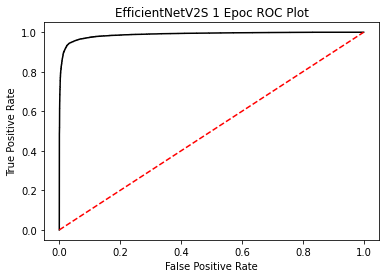

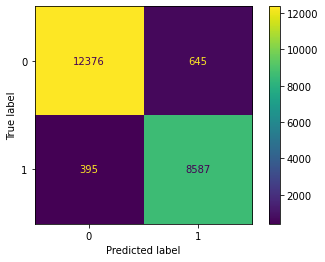

In [ ]:
eval(model, val_data['label'], val_imgs, "EfficientNetV2S 1 Epoc")

Scores for EfficientNetV2S 2 Epocs:
 F1: 0.9508646719736482 
 Precision: 0.9379399978338568
 Recall: 0.9641505232687597
 Accuracy: 0.9593237285824661
 AUC: 0.9918675937407587


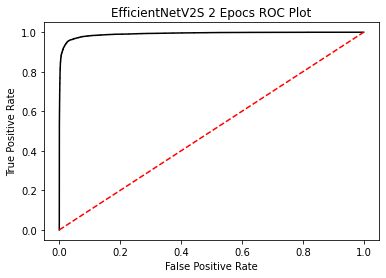

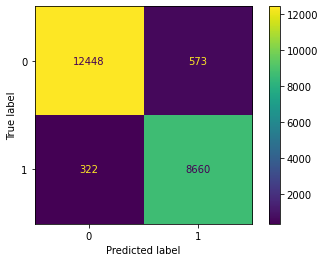

In [ ]:
eval(model_Efficient, val_data['label'], val_imgs, "EfficientNetV2S 2 Epocs")

Scores for ResNet50:
 F1: 0.9105080502929965 
 Precision: 0.9310063990692263
 Recall: 0.8908928969049209
 Accuracy: 0.9285097486706358
 AUC: 0.9777690701270448


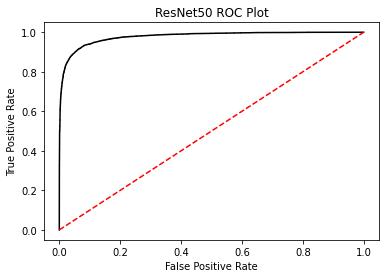

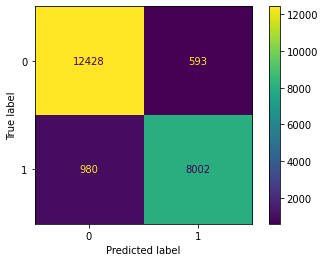

In [ ]:
eval(model_ResNet, val_data['label'], val_imgs, "ResNet50")

Scores for VGG19:
 F1: 0.9168618936060797 
 Precision: 0.941777203897171
 Recall: 0.8932309062569583
 Accuracy: 0.9338726537290369
 AUC: 0.9803329790591774


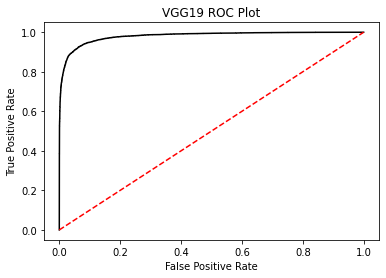

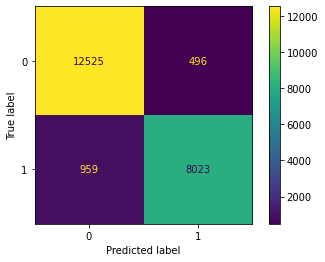

In [ ]:
eval(model_VGG19, val_data['label'], val_imgs, "VGG19")

|   | F1| Precision | Recall | Accuracy  | AUC  |
|---|---|---|---|---|---|
| EfficientNetV2S_1  | 0.94  | 0.93 |  0.96 | 0.95  | 0.99  |   |   |
| EfficientNetV2S_2  |  0.95 |  0.94 | 0.96  | 0.96  | 0.99  |   |   |
| ResNet50  | 0.91  | 0.93  | 0.89  | 0.93  | 0.93  | 0.98  |   | 
| VGG19  |  0.92 | 0.94  | 0.89  | 0.93  | 0.98  |   |   |

Based on the chosen metrics, the EfficientNetV2S model is by far the best performing model. The ResNet50 and VGG19 perform similarly, indicating that the both architectures learned the data in a similar manner. It appears that all the models have a similar and high precision score (i.e. if an image is classified as cancer, then its very like that it really is cancer). 

The EfficientNetV2S model learned to correctly identify more positives (cancer), as evidenced by its significantly higher recall score. It seems that this model was able to learn some subtle characteristics about cancer that the other models could not. This could be a consequence of its deep architecture. 

In this context, the recall score is perhaps the most important metric. It is critical that a model classifies someone who actually has cancer as positive, since a false negative could be life-threatening.

The scores associated with 1 epoc EfficientNetV2S do not differ significantly from the 2 epoc EfficientNetV2S scores. Training the EfficientNet model for a longer duration is likely not worthwhile. Therefore, I believe that the EfficientNetV2S_1 model is the best model.

Take note that the fine-tuning step can introduce error into the model if certain steps are not taken. To troubleshoot this problem, make sure that all batch normalization layers are non trainable. In addition, reduce the learning rate by an order of magnitude until desirable results are attained.

### Conclusion
Based on my analysis, a neural network trained on features extracted using the newer EfficientNetV2S base model outperforms ResNet50 and VGG19.

#### Experiment Results
One epoc is sufficient for training a good metastatic cancer detector. Beyond that, there is high generalization error. On the other hand, the additional fine-tuning step significantly improved the performance of the transfer learning models discussed in this study.

#### Future Work
I believe that an ensemble of neural networks may be the best model for detecting metastatic cancer. Generalization error can be reduced by using the input of various models of different architectures trained on different subsets of data. In the future, the various models discussed in this study could be retrained on subsets of the training data and ensembled into a single, powerful classifier. 

In [ ]:
#process test images
test_data = pd.read_csv("histopathologic-cancer-detection/sample_submission.csv")
test_data['id'] = test_data['id'] + ".tif"
test_data['label'] = test_data['label'].astype('str')
test_imgs = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255.0,
).flow_from_dataframe(
              dataframe=test_data,
              directory="histopathologic-cancer-detection/test",
              x_col="id",
              y_col="label",
              batch_size = 128,
              shuffle=False,
              target_size=(96,96))

Found 57458 validated image filenames belonging to 1 classes.


In [ ]:
samp_test = next(iter(test_imgs))

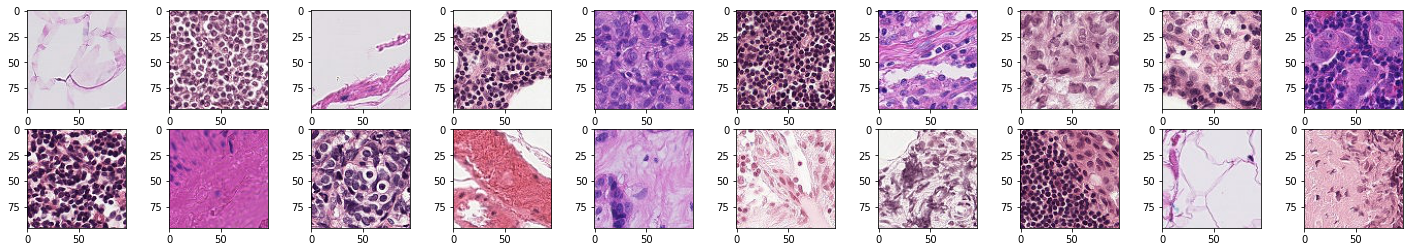

In [ ]:
plt.figure(figsize=(25,4))
for (i,img) in enumerate(samp_test[0][:20]):
  plt.subplot(2, 10, i+1)
  plt.imshow(img / 255.)

In [ ]:
pred = model.predict(test_imgs)

In [ ]:
submit = pd.read_csv("histopathologic-cancer-detection/sample_submission.csv")
submit['label'] = pred.reshape(-1)
submit.head()
submit.to_csv("submit.csv", index=False)